In [1]:
import sys
sys.path.append("..")

from generators.random_forest_generator import RFGenerator
from generators.p4_code_generator import P4CodeGenerator

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os, glob
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn.utils import shuffle
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from sklearn.tree import _tree


In [2]:
######################################## parameter setting ########################################
flow_length = 8
relevant_features_num = 20
with_slice = True

rf_gen = RFGenerator()

######################################## feature paths ########################################
feature_list_path = "../../dataset/features_with_id.csv"
feature_importance_logger_path = "../../logs/feature_importance/computation_feature_importance_logger.log"

feature_scores_path = f"../../outputs/feature_importance/balanced_wo_time/balanced_wo_time_equal_{flow_length}/feature_scores_balanced_wo_time_equal_{flow_length}.csv"
feature_fig_path = f"../../outputs/feature_importance/balanced_wo_time/balanced_wo_time_equal_{flow_length}/feature_scores_balanced_wo_time_equal_{flow_length}.png"

######################################## training paths ########################################
grid_search_results_path = f"../../outputs/hyperparameters/balanced_wo_time/balanced_wo_time_equal_{flow_length}/grid_search_results_balanced_wo_time_equal_{flow_length}"

######################################## merged dataset paths ########################################
dataset_preprocessed_merged_balanced_path = f"../../dataset/balanced/balanced_equal_{flow_length}/preprocessed_balanced_equal_{flow_length}_merged.csv"
dataset_preprocessed_merged_balanced_wo_time_path = f"../../dataset/balanced_wo_time/balanced_wo_time_equal_{flow_length}/preprocessed_balanced_wo_time_equal_{flow_length}_merged.csv"
dataset_relevant_merged_balanced_wo_time_path = f"../../dataset/balanced_wo_time/balanced_wo_time_equal_{flow_length}/relevant_balanced_wo_time_equal_{flow_length}_merged_f_{relevant_features_num}.csv"

######################################## serialization paths ########################################
feature_compatible_serialiazation_path = f"../../outputs/serialization/balanced_wo_time/feature_compatible_wo_time_equal_{flow_length}_serialized.pkl"
feature_relevant_serialiazation_path = f"../../outputs/serialization/balanced_wo_time/feature_relevant_balanced_wo_time_equal_{flow_length}_f_{relevant_features_num}_serialized.pkl"

######################################## P4 paths ########################################
p4_code_path = f"../../outputs/p4_code/balanced_wo_time/balanced_wo_time_equal_{flow_length}/"

######################################## sliced .csv paths ########################################
dataset_path = "../../../datasets/"
dataset_sliced_flow_path_list = glob.glob(os.path.join(dataset_path, f"*-WorkingHours_sliced_flow_{flow_length}.csv"))


Start building Random Forest


In [3]:
################################### preprocess datasets and concatenate them to one file ###################################
# total benign flows number = total attack flows number
# removed duplicated benign flows

# categorical features. 
categorical_features = ['protocol',   
                        'splt_direction_1',
                        'splt_direction_2',
                        'splt_direction_3',
                        'splt_direction_4',
                        'splt_direction_5',
                        'splt_direction_6',
                        'splt_direction_7',
                        'splt_direction_8']

# eliminate NFlow core features
features_to_eliminate = ['id',
                         'expiration_id',
                         'src_ip',
                         'src_mac',
                         'src_oui',
                         'src_port',
                         'dst_ip',
                         'dst_mac',
                         'dst_oui',
                         'dst_port',
                         'ip_version',
                         'vlan_id',
                         'tunnel_id',
                         'bidirectional_first_seen_ms',
                         'bidirectional_last_seen_ms',
                         'src2dst_first_seen_ms',
                         'src2dst_last_seen_ms',
                         'dst2src_first_seen_ms',
                         'dst2src_last_seen_ms',
                         'bidirectional_stddev_ps',
                         'src2dst_stddev_ps',
                         'dst2src_stddev_ps',
                         'bidirectional_stddev_piat_ms',
                         'src2dst_stddev_piat_ms',
                         'dst2src_stddev_piat_ms']

# splt features (should be added with 1 to avoid -1)
splt_features = ['splt_piat_ms_1',
        	     'splt_piat_ms_2',
        	     'splt_piat_ms_3',
        	     'splt_piat_ms_4',
        	     'splt_piat_ms_5',
        	     'splt_piat_ms_6',
        	     'splt_piat_ms_7',
        	     'splt_piat_ms_8',
        	     'splt_ps_1',
        	     'splt_ps_2',
        	     'splt_ps_3',
        	     'splt_ps_4',
        	     'splt_ps_5',
        	     'splt_ps_6',
        	     'splt_ps_7',
        	     'splt_ps_8',
                 'splt_direction_1',
                 'splt_direction_2',
                 'splt_direction_3',
                 'splt_direction_4',
                 'splt_direction_5',
                 'splt_direction_6',
                 'splt_direction_7',
                 'splt_direction_8']

rf_gen.preprocess_file_no_duplicate(csv_pathes=dataset_sliced_flow_path_list,
                                            save_path=dataset_preprocessed_merged_balanced_path,
                                            packets_num=flow_length,
                                            drop_columns=features_to_eliminate, 
                                            categorical_columns=categorical_features, 
                                            splt_columns=splt_features)

Wednesday dataset has been labeled
Tuesday dataset has been labeled
Friday dataset has been labeled
Thursday dataset has been labeled
Sample number (Number of attack flow without duplicated entries): 6947
Tuesday balanced dataset: 13894 flows
Sample number (Number of attack flow without duplicated entries): 24957
Tuesday balanced dataset: 49914 flows
Sample number (Number of attack flow without duplicated entries): 10452
Tuesday balanced dataset: 20904 flows
Sample number (Number of attack flow without duplicated entries): 64479
Tuesday balanced dataset: 128958 flows
The unit of time related features have to be converted to microsecond


,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,...,splt_direction_4_2,splt_direction_5_1,splt_direction_5_2,splt_direction_6_1,splt_direction_6_2,splt_direction_7_1,splt_direction_7_2,splt_direction_8_1,splt_direction_8_2,Label
13866,75000,8,2957,75000,4,121,38000,4,2836,0,...,0,0,1,0,1,0,1,1,0,0
18834,50000,8,720,50000,5,568,25000,3,152,0,...,0,0,1,0,1,1,0,1,0,0
338656,1876000,8,11615,1000,3,20,1876000,5,11595,0,...,0,0,1,0,1,0,1,0,1,1
423166,479000,8,11615,0,3,20,479000,5,11595,0,...,0,0,1,0,1,0,1,0,1,1
57778,1560000,8,1799,1415000,5,534,1416000,3,1265,0,...,0,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352,232000,8,3091,232000,4,195,121000,4,2896,0,...,0,0,1,0,1,1,0,0,1,0
489795,81000,8,11615,0,3,20,81000,5,11595,0,...,0,0,1,0,1,0,1,0,1,1
5248,32000,8,1680,32000,4,136,0,4,1544,34,...,0,0,1,0,1,0,1,0,1,0
340041,71000,8,2694,71000,4,427,37000,4,2267,0,...,0,0,1,0,1,0,1,1,0,1


In [3]:
################################### remove uncomapatible features ###################################
df = pd.read_csv(dataset_preprocessed_merged_balanced_path)

time_realated_features = ["bidirectional_duration_ms", 
                          "bidirectional_min_piat_ms", 
                          "bidirectional_mean_piat_ms", 
                          "bidirectional_max_piat_ms", 
                          "src2dst_duration_ms", 
                          "src2dst_min_piat_ms", 
                          "src2dst_mean_piat_ms", 
                          "src2dst_max_piat_ms", 
                          "dst2src_duration_ms", 
                          "dst2src_min_piat_ms", 
                          "dst2src_mean_piat_ms", 
                          "dst2src_max_piat_ms", 
                          "splt_piat_ms_1", 
                          "splt_piat_ms_2", 
                          "splt_piat_ms_3", 
                          "splt_piat_ms_4", 
                          "splt_piat_ms_5", 
                          "splt_piat_ms_6", 
                          "splt_piat_ms_7", 
                          "splt_piat_ms_8"]

other_unuseful_features = ["bidirectional_packets",
                           "src2dst_mean_ps",
                           "dst2src_mean_ps"]

protocol_features = ['protocol_1', 
                     'protocol_2', 
                     'protocol_6', 
                     'protocol_17', 
                     'protocol_58',
                     'protocol_132']

features_to_eliminate = time_realated_features + other_unuseful_features + protocol_features

# round down the bidirectional_mean_ps feature
# why? computing the mean of 8 packets can be done in P4
df["bidirectional_mean_ps"] = df["bidirectional_mean_ps"].apply(lambda x: math.floor(x))

# drop the uncompatible features 
df = df.drop(features_to_eliminate, axis=1)

df.to_csv(dataset_preprocessed_merged_balanced_wo_time_path, index=False)

In [5]:
# compute the feature importances 
type_string = f"Balanced without time related features Equal {flow_length}"
feature_importances = rf_gen.compute_feature_importances(data_path=dataset_preprocessed_merged_balanced_wo_time_path, 
                                                        feature_scores_save_path=feature_scores_path, 
                                                        type_str=type_string,
                                                        repeat_time=3, 
                                                        record_logging=True, 
                                                        logging_path=feature_importance_logger_path)

In [7]:
################################### round the feature importance scores ###################################
df = pd.read_csv(feature_scores_path)
save_path = feature_scores_path[:-4] + "_rounded.csv"
df = df.round(3)
df.to_csv(save_path, index=False)


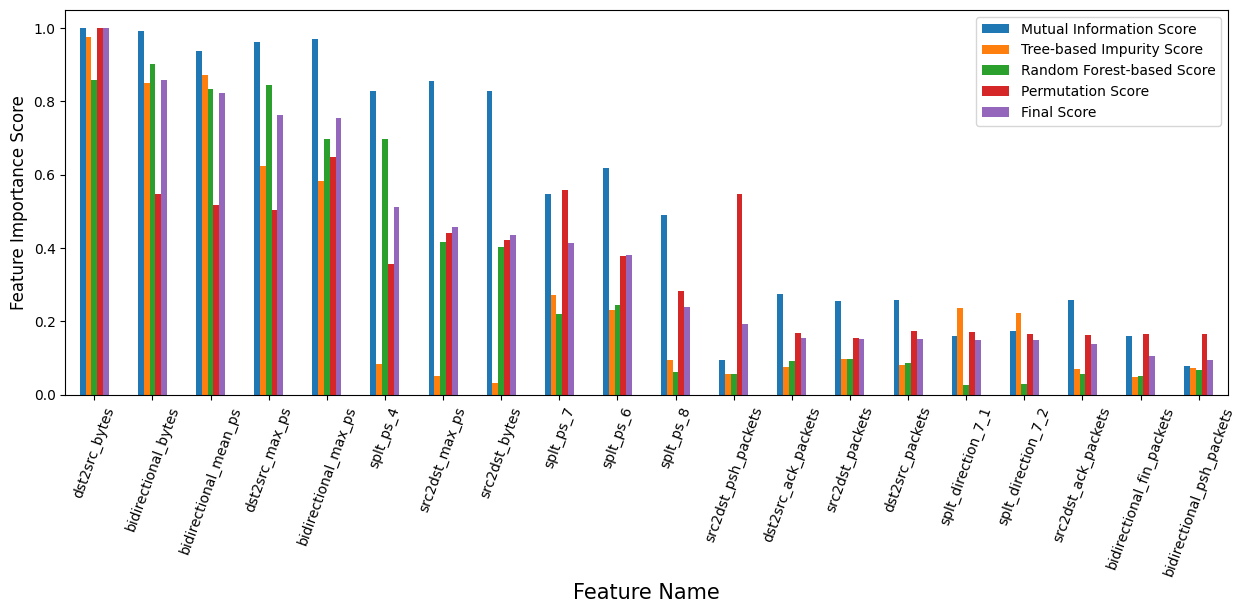

In [3]:
# extract data of relevant features, plot relevant feature scores 
title = f"Feature Importance Scores of {relevant_features_num} Most Relevant Features"
rf_gen.get_relevant_features(feature_scores_path=feature_scores_path, 
                         original_dataset_path=dataset_preprocessed_merged_balanced_wo_time_path, 
                         dataset_relevant_save_path=dataset_relevant_merged_balanced_wo_time_path, 
                         fig_path=feature_fig_path,
                         fig_title=title,
                         relevant_features_num=relevant_features_num, 
                         plot_relevant_feature=True)

In [9]:
X_train, X_test, y_train, y_test = rf_gen.split_dataset(dataset_path=dataset_relevant_merged_balanced_wo_time_path)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score: 0.9569374011615788
Best parameters: {'max_depth': 10, 'n_estimators': 3}


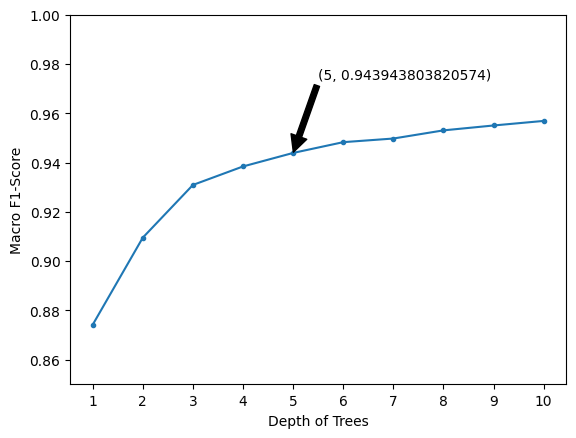

In [40]:
################################### search for the best maximum depth (tree number: 3) ###################################
params = {
        "n_estimators": [3],
        "max_depth": range(1, 11)
        }

estimator, path = rf_gen.get_best_estimator(cv_results_path=grid_search_results_path, params=params, X_train=X_train, y_train=y_train)

df = pd.read_csv(path, index_col="param_max_depth")
ax = df["mean_test_score"].plot(style=".-", 
                        xlabel="Depth of Trees", 
                        ylabel="Macro F1-Score", 
                        xticks=params["max_depth"], 
                        ylim=[0.85, 1],
                        rot=1)

# get the value of a specific point
point_x = 5
point_y = df['mean_test_score'][5]

# add the value to the point in the chart
ax.annotate(f'({point_x}, {point_y})', xy=(point_x, point_y), xytext=(point_x + 0.5, point_y + 0.03),
            arrowprops=dict(facecolor='black', shrink=0.01))
            

fig_path = path[:-4] + ".png"
# plt.savefig(fig_path)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: 0.9552559430814215
Best parameters: {'max_depth': 9, 'n_estimators': 5}


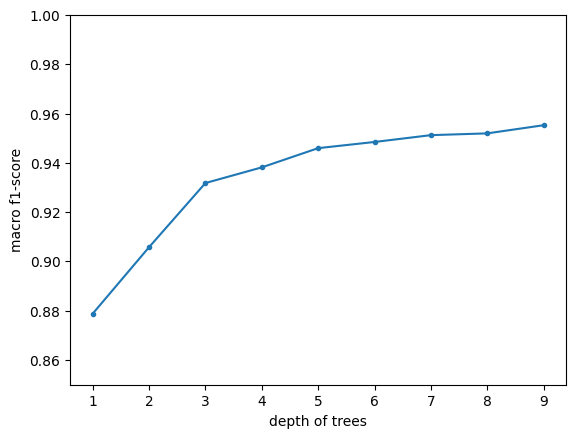

In [37]:
################################### search for the best maximum depth (tree number: 3) ###################################
params = { 
        "n_estimators": [5],
        "max_depth": range(1, 10)
        }

estimator, path = rf_gen.get_best_estimator(cv_results_path=grid_search_results_path, params=params, X_train=X_train, y_train=y_train)

df = pd.read_csv(path, index_col="param_max_depth")
df["mean_test_score"].plot(style=".-", 
                        title=f"F1-score related to the maximum depth of trees (tree number: {params['n_estimators'][0]})", 
                        xlabel="depth of trees", 
                        ylabel="macro f1-score", 
                        xticks=params["max_depth"], 
                        rot=1)

fig_path = path[:-4] + ".png"
plt.savefig(fig_path)

In [3]:
df = pd.read_csv(dataset_relevant_merged_balanced_wo_time_path)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     31783
           1       1.00      0.92      0.96     32318

    accuracy                           0.96     64101
   macro avg       0.96      0.96      0.96     64101
weighted avg       0.96      0.96      0.96     64101



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


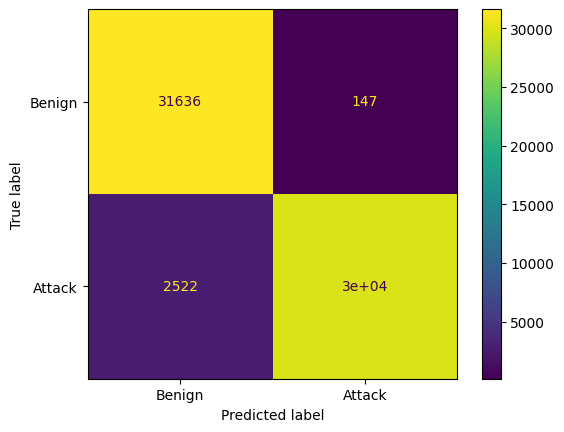

In [6]:
################################### train the rf estimater (best parameters: 3 trees, 5 maximum depth) ###################################
n_estimators = 3
max_depth = 11
# rf_serialization_path = f"../../outputs/serialization/balanced_wo_time/rf_balanced_wo_time_equal_{flow_length}_n_estimators_{n_estimators}_max_depth_{max_depth}_seralized.pkl"
# path for switchtree
rf_serialization_path = f"../../outputs/serialization/switchtree/switchtree_n_estimators_{n_estimators}_max_depth_{max_depth}_seralized.pkl"

tree_fig_path = f"../../outputs/tree_structure/balanced_wo_time/balanced_wo_time_equal_{flow_length}_n_estimators_{n_estimators}_max_depth_{max_depth}"

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
X_train, X_test, y_train, y_test = rf_gen.split_dataset(dataset_path=dataset_relevant_merged_balanced_wo_time_path)
rf = rf.fit(X_train, y_train)

# plot and save the trees
# rf_gen.plot_trees(save_path=tree_fig_path, 
#                   rf_estimator=rf,
#                   features=X_train.columns)

# save the rf estimator in pkl file
rf_gen.save_rf(rf_serialization_path, rf)

# show the evaluation
y_predict = rf.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(rf, X_test, y_test, display_labels=["Benign", "Attack"])

In [10]:
################################### extract and save the compatible features ###################################
basic_features = ['id',
                 'expiration_id',
                 'src_ip',
                 'src_mac',
                 'src_oui',
                 'src_port',
                 'dst_ip',
                 'dst_mac',
                 'dst_oui',
                 'dst_port',
                 'protocol',
                 'ip_version',
                 'vlan_id',
                 'tunnel_id']
# time related features except bidirectional_first_seen_ms which is used to expire flow in P4
time_features = ['bidirectional_last_seen_ms',
                 'bidirectional_duration_ms',
                 'src2dst_first_seen_ms',
                 'src2dst_last_seen_ms',
                 'src2dst_duration_ms',
                 'dst2src_first_seen_ms',
                 'dst2src_last_seen_ms',
                 'dst2src_duration_ms',
                 'bidirectional_min_piat_ms',
                 'bidirectional_mean_piat_ms',
                 'bidirectional_max_piat_ms',
                 'src2dst_min_piat_ms',
                 'src2dst_mean_piat_ms',
                 'src2dst_max_piat_ms',
                 'dst2src_min_piat_ms',
                 'dst2src_mean_piat_ms',
                 'dst2src_max_piat_ms',
                 'splt_piat_ms_1',
                 'splt_piat_ms_2',
                 'splt_piat_ms_3',
                 'splt_piat_ms_4',
                 'splt_piat_ms_5',
                 'splt_piat_ms_6',
                 'splt_piat_ms_7',
                 'splt_piat_ms_8']
# stddev related features
stddev_features = ['bidirectional_stddev_ps',
                   'src2dst_stddev_ps',
                   'dst2src_stddev_ps',
                   'bidirectional_stddev_piat_ms',
                   'src2dst_stddev_piat_ms',
                   'dst2src_stddev_piat_ms']

# protocol features
protocol_features = ['protocol_1',
                     'protocol_2',
                     'protocol_6',
                     'protocol_17',
                     'protocol_58',
                     'protocol_132']

# mean_ps related features except bidirectional_mean_ps
mean_ps_features = ['src2dst_mean_ps', 'dst2src_mean_ps']

features_to_eliminate = basic_features + time_features + stddev_features + protocol_features + mean_ps_features

# read the feature with id file and remove the unused faetures
features_compatible = pd.read_csv(feature_list_path)["feature"].tolist()
for f in features_to_eliminate:
    features_compatible.remove(f)

with open(feature_compatible_serialiazation_path, "wb") as f:
    pickle.dump(features_compatible, f)

In [15]:
################################### save the relevant features ###################################
features_relevant = pd.read_csv(feature_scores_path, index_col=0).index.tolist()[:relevant_features_num]

with open(feature_relevant_serialiazation_path, "wb") as f:
    pickle.dump(features_relevant, f)

In [7]:
################################### generate P4 code ###################################
n_estimators = 3
max_depth = 11
# rf_serialization_path = f"../../outputs/serialization/balanced_wo_time/rf_balanced_wo_time_equal_{flow_length}_n_estimators_{n_estimators}_max_depth_{max_depth}_seralized.pkl"

# path for switchtree
rf_serialization_path = f"../../outputs/serialization/switchtree/switchtree_n_estimators_{n_estimators}_max_depth_{max_depth}_seralized.pkl"

# get the compatible features from pkl
with open(feature_compatible_serialiazation_path, "rb") as f:
    features_compatible = pickle.load(f)

# get relevant features from pkl
with open(feature_relevant_serialiazation_path, "rb") as f:
    features_relevant = pickle.load(f)

# get rf estimator from pkl
with open(rf_serialization_path, "rb") as f:
    rf = pickle.load(f)

p4_gen = P4CodeGenerator(rf_estimator=rf, 
                         full_features=features_compatible, 
                         relevant_features=features_relevant, 
                         save_path=p4_code_path, 
                         features_path=feature_list_path)
    
p4_gen.generate_p4_rules()
p4_gen.generate_struct_to_bitstring_action()
p4_gen.generate_bitstring_to_struct_action()
p4_gen.generate_compare_feature_action()
p4_gen.generate_mathch_action_tables()
p4_gen.generate_classfication_logic()

P4 code generator
Generated P4 rules.
Generated struct to bistring code.
Generated bistring to struct code.
Generated compare feature action code
Generated match action table code
Generated classification logic code


size of dataset: 213670


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.93      1.00      0.96    106835
           1       1.00      0.92      0.96    106835

    accuracy                           0.96    213670
   macro avg       0.96      0.96      0.96    213670
weighted avg       0.96      0.96      0.96    213670



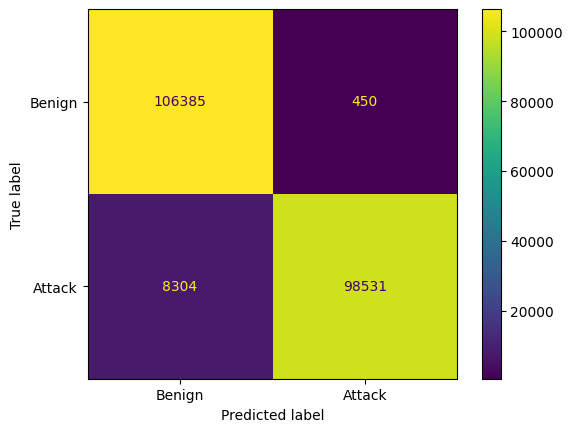

In [8]:
################################### switchtree ###################################
# get rf estimator from pkl
rf_serialization_path = f"../../outputs/serialization/switchtree/switchtree_n_estimators_{n_estimators}_max_depth_{max_depth}_seralized.pkl"
with open(rf_serialization_path, "rb") as f:
    rf = pickle.load(f)
    
df = pd.read_csv(dataset_relevant_merged_balanced_wo_time_path)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(f"size of dataset: {len(y)}")
plot_confusion_matrix(rf, X, y, display_labels=["Benign", "Attack"])

y_predict = rf.predict(X)
print(classification_report(y, y_predict))

In [5]:
n_estimators = 3
max_depth = 5
rf_serialization_path = f"../../outputs/serialization/balanced_wo_time/rf_balanced_wo_time_equal_{flow_length}_n_estimators_{n_estimators}_max_depth_{max_depth}_seralized.pkl"

size of dataset: 213670


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.91      0.99      0.95    106835
           1       0.99      0.90      0.94    106835

    accuracy                           0.94    213670
   macro avg       0.95      0.94      0.94    213670
weighted avg       0.95      0.94      0.94    213670



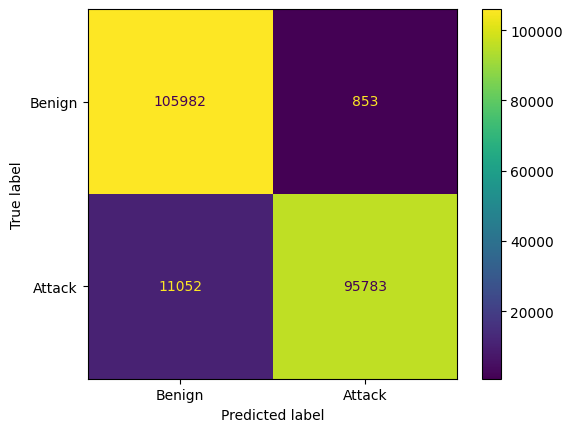

In [6]:
################################### compute the confusion matrix for entire dataset ###################################
# get rf estimator from pkl
with open(rf_serialization_path, "rb") as f:
    rf = pickle.load(f)
    
df = pd.read_csv(dataset_relevant_merged_balanced_wo_time_path)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(f"size of dataset: {len(y)}")
plot_confusion_matrix(rf, X, y, display_labels=["Benign", "Attack"])

y_predict = rf.predict(X)
print(classification_report(y, y_predict))

['dst2src_bytes', 'bidirectional_bytes', 'bidirectional_mean_ps', 'dst2src_max_ps', 'bidirectional_max_ps', 'splt_ps_4', 'src2dst_max_ps', 'src2dst_bytes', 'splt_ps_7', 'splt_ps_6', 'splt_ps_8', 'src2dst_psh_packets', 'dst2src_ack_packets', 'src2dst_packets', 'dst2src_packets', 'splt_direction_7_1', 'splt_direction_7_2', 'src2dst_ack_packets', 'bidirectional_fin_packets', 'bidirectional_psh_packets']
------------------------- Tuesday-Wo -------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     99209
           1       0.64      1.00      0.78      6947

    accuracy                           0.96    106156
   macro avg       0.82      0.98      0.88    106156
weighted avg       0.98      0.96      0.97    106156

------------------------- Wednesday- -------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.98      0.97      0.98    100434
           1       0.88      0.94      0.91     24957

    accuracy                           0.96    125391
   macro avg       0.93      0.95      0.94    125391
weighted avg       0.96      0.96      0.96    125391

------------------------- Thursday-W -------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.90      0.96      0.93     80299
           1       0.37      0.17      0.23     10452

    accuracy                           0.87     90751
   macro avg       0.64      0.57      0.58     90751
weighted avg       0.84      0.87      0.85     90751

------------------------- Friday-Wor -------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.96      0.98     85824
           1       0.95      0.99      0.97     64479

    accuracy                           0.97    150303
   macro avg       0.97      0.98      0.97    150303
weighted avg       0.97      0.97      0.97    150303



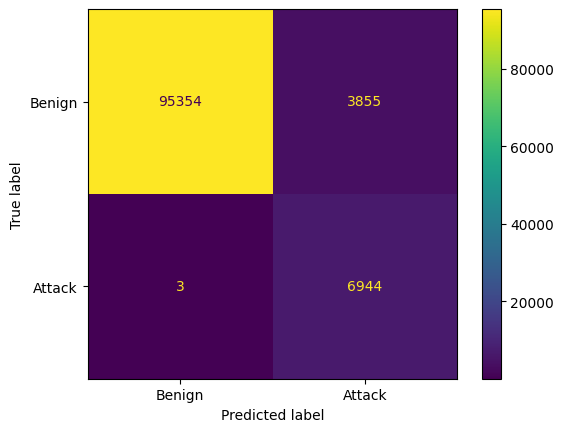

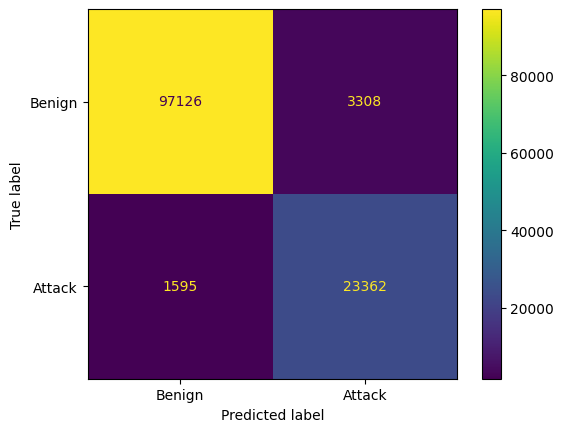

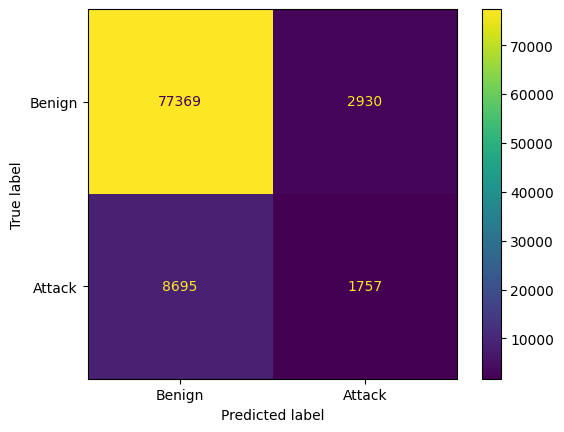

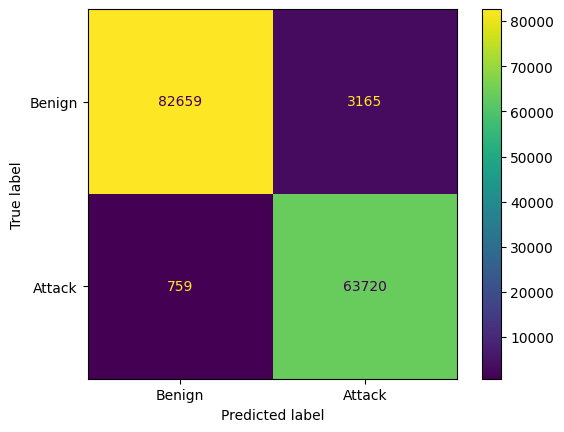

In [7]:
dataset_pathes = [
    f"../../../datasets/Tuesday-WorkingHours_sliced_flow_{flow_length}_preprocessed.csv",
    f"../../../datasets/Wednesday-WorkingHours_sliced_flow_{flow_length}_preprocessed.csv",
    f"../../../datasets/Thursday-WorkingHours_sliced_flow_{flow_length}_preprocessed.csv",
    f"../../../datasets/Friday-WorkingHours_sliced_flow_{flow_length}_preprocessed.csv"
]

# read rf
with open(rf_serialization_path, "rb") as f:
    rf = pickle.load(f)

# read relevant features
with open(feature_relevant_serialiazation_path, "rb") as f:
    relevant_features_index = pickle.load(f)
print(relevant_features_index)

for dataset_path in dataset_pathes:
    df = pd.read_csv(dataset_path)
    df = df[df["bidirectional_packets"] == flow_length]

    # round down the mean feature
    mean_features = ["bidirectional_mean_ps",
                 "src2dst_mean_ps",
                 "dst2src_mean_ps"]
    for feature in mean_features:
        df[feature] = df[feature].apply(lambda x: math.floor(x))

    # extract the relevant features
    df = df[relevant_features_index + ["Label"]]
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    print(f"------------------------- {dataset_path[18: 28]} -------------------------")
    plot_confusion_matrix(rf, X, y, display_labels=["Benign", "Attack"])
    y_predict = rf.predict(X)
    print(classification_report(y, y_predict))